In [1]:
import datajoint as dj
import numpy as np
import time

In [8]:
schema = dj.schema('microns_ta3p100')
ta3p100 = dj.create_virtual_module('ta3p100', 'microns_ta3p100')

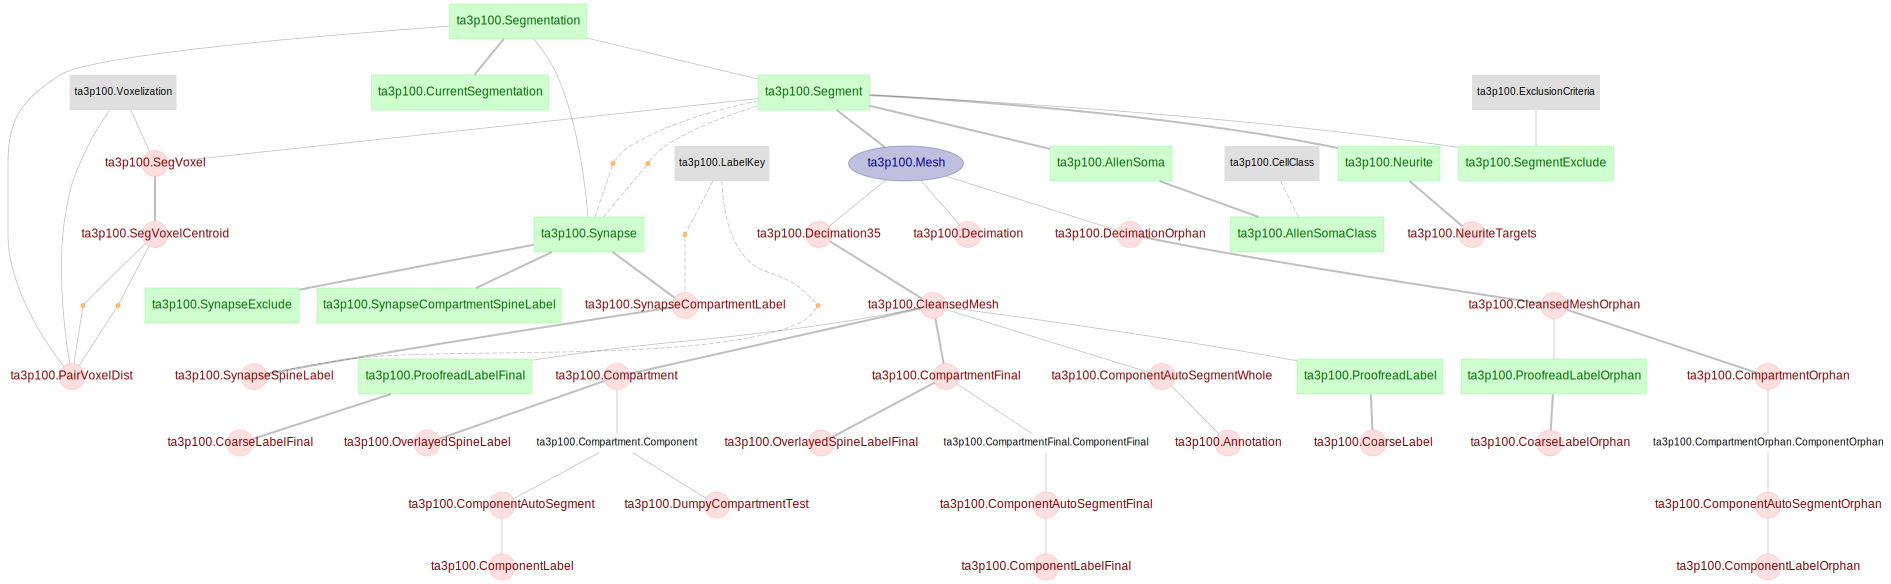

In [3]:
dj.ERD(ta3p100)

In [5]:
@schema
class OverlayedSpineLabelOrphan(dj.Computed):
    definition = """
    # Segment labels with Spine labels overlayed (replacing) normal component labels.
    -> ta3p100.CompartmentOrphan
    ---
    vertices             : longblob                     
    triangles            : longblob  
    """

In [6]:
dj.config['display.limit'] = 15

In [9]:
@schema
class OverlayedSpineLabelOrphan(dj.Computed):
    definition = ta3p100.OverlayedSpineLabelOrphan.describe()
    
    def make(self, key):
#         print(key['segment_id'])
#         start = time.time()
        
        corrected_labels = (ta3p100.CoarseLabelOrphan & key).fetch1()
        
        compartment_key = dict(segmentation=key['segmentation'], segment_id=key['segment_id'], decimation_ratio=0.35)
        components = (ta3p100.CompartmentOrphan.ComponentOrphan & compartment_key
                      & [dict(compartment_type=compartment) for compartment in ["Apical", "Oblique", "Basal"]]).fetch()
        
        non_existence_count = 0
        component_spine_match = []
        for component in components:
            component_key = dict(compartment_key, compartment_type=component[3], component_index=component[4])
            try:
                component_labels = (ta3p100.ComponentLabelOrphan & component_key).fetch()
                n_heads = list(zip(*component_labels))[12]
#                 min_n_heads = np.min(n_heads)
#                 index_supposed_best_fit = np.where(n_heads==min_n_heads)[0][0]#[-1]
#                 component_spine_match.append((component, list(component_labels[index_supposed_best_fit])[8:12]))
                component_spine_match.append((component, list(component_labels[0])[8:12]))
            except:
                non_existence_count += 1
                pass
#         print(f"{non_existence_count} components did not have spine data.")
        for match in component_spine_match:
            if not np.array_equal(list(match[0])[5:7], list(match[1])[:2]):
                print("Ruh-roh the sizes of the component and component_label array don't match.")
        
        corrected_vertex_labels = corrected_labels['vertices']
        corrected_triangle_labels = corrected_labels['triangles']

        new_complete_vertex_labels = corrected_vertex_labels.copy()
        for match in component_spine_match:
            vertex_indices = match[0][7]
            spine_vertex_labels = match[1][2].astype(np.uint8)
            overlayed_vertex_labels = np.array([corrected_vertex_labels[vertex_indices], spine_vertex_labels]).max(axis=0)
            new_complete_vertex_labels[vertex_indices] = overlayed_vertex_labels

        new_complete_triangle_labels = corrected_triangle_labels.copy()
        for match in component_spine_match:
            triangle_indices = match[0][8]
            spine_triangle_labels = match[1][3].astype(np.uint8)
            overlayed_triangle_labels = np.array([corrected_triangle_labels[triangle_indices], spine_triangle_labels]).max(axis=0)
            new_complete_triangle_labels[triangle_indices] = overlayed_triangle_labels
        
        self.insert1(dict(key,
                          vertices=new_complete_vertex_labels,
                          triangles=new_complete_triangle_labels))
        
#         print(time.time() - start, "\n")

# Segment labels with Spine labels overlayed (replacing) normal component labels.
-> ta3p100.CompartmentOrphan
---
vertices             : longblob                     
triangles            : longblob                     



In [10]:
start = time.time()
OverlayedSpineLabelOrphan.populate()
print(time.time() - start)

23.966157913208008
